<a href="https://colab.research.google.com/github/Rohit5890/CodeTheGrid_GridPredict/blob/main/Race.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Round 1

In [1]:
pip install kagglehub

In [2]:
import kagglehub

path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")

print("Path to dataset files:", path)

100%|██████████| 6.28M/6.28M [00:00<00:00, 27.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rohanrao/formula-1-world-championship-1950-2020/versions/24


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

[21, 21, 21, 21]


<ipython-input-53-d4a898fdcb45>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['grid'] = pd.to_numeric(data['grid'], errors='coerce').fillna(data['grid'].median())
<ipython-input-53-d4a898fdcb45>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['points_x'] = pd.to_numeric(data['points_x'], errors='coerce').fillna(0)
<ipython-input-53-d4a898fdcb45>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

         avg_finish_position  podium_finishes  total_points       grid  \
surname                                                                  
Albon              14.333333                0          65.0  12.666667   
Sainz               6.000000                0         210.0   7.250000   

            year  points_x  position_y  avg_lap_time  fastest_lap_time  \
surname                                                                  
Albon    2022.00       0.0   14.333333  86884.652505      79736.000000   
Sainz    2021.75      26.0    6.000000  96399.195446      82323.941085   

         lap_time_stddev  
surname                   
Albon       13642.528099  
Sainz       63333.755399  


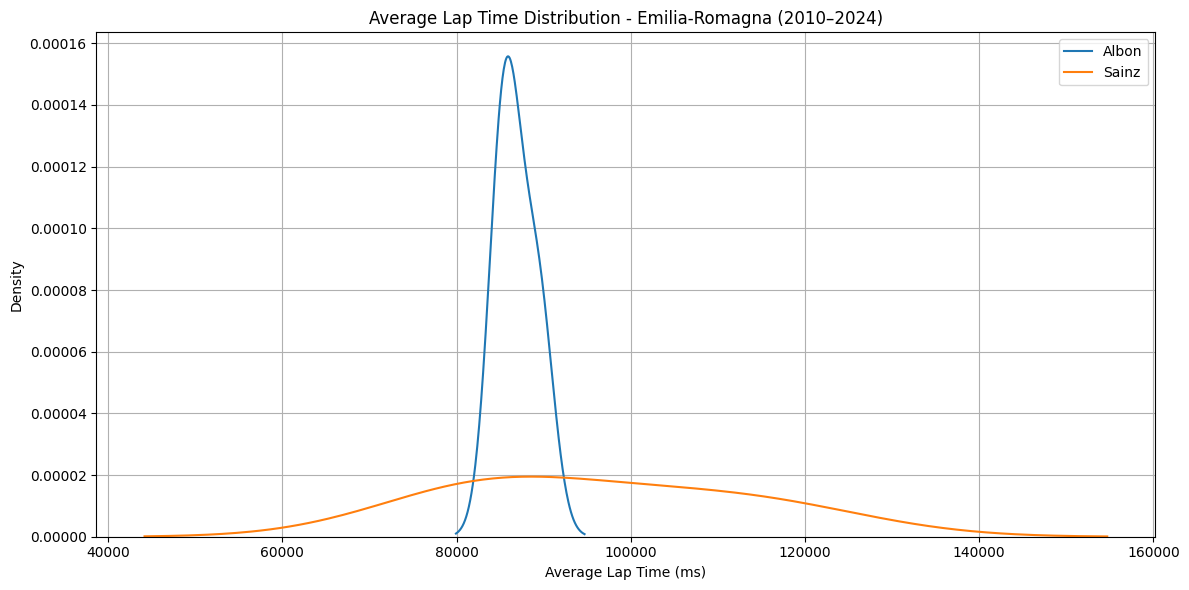

<ipython-input-53-d4a898fdcb45>:109: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


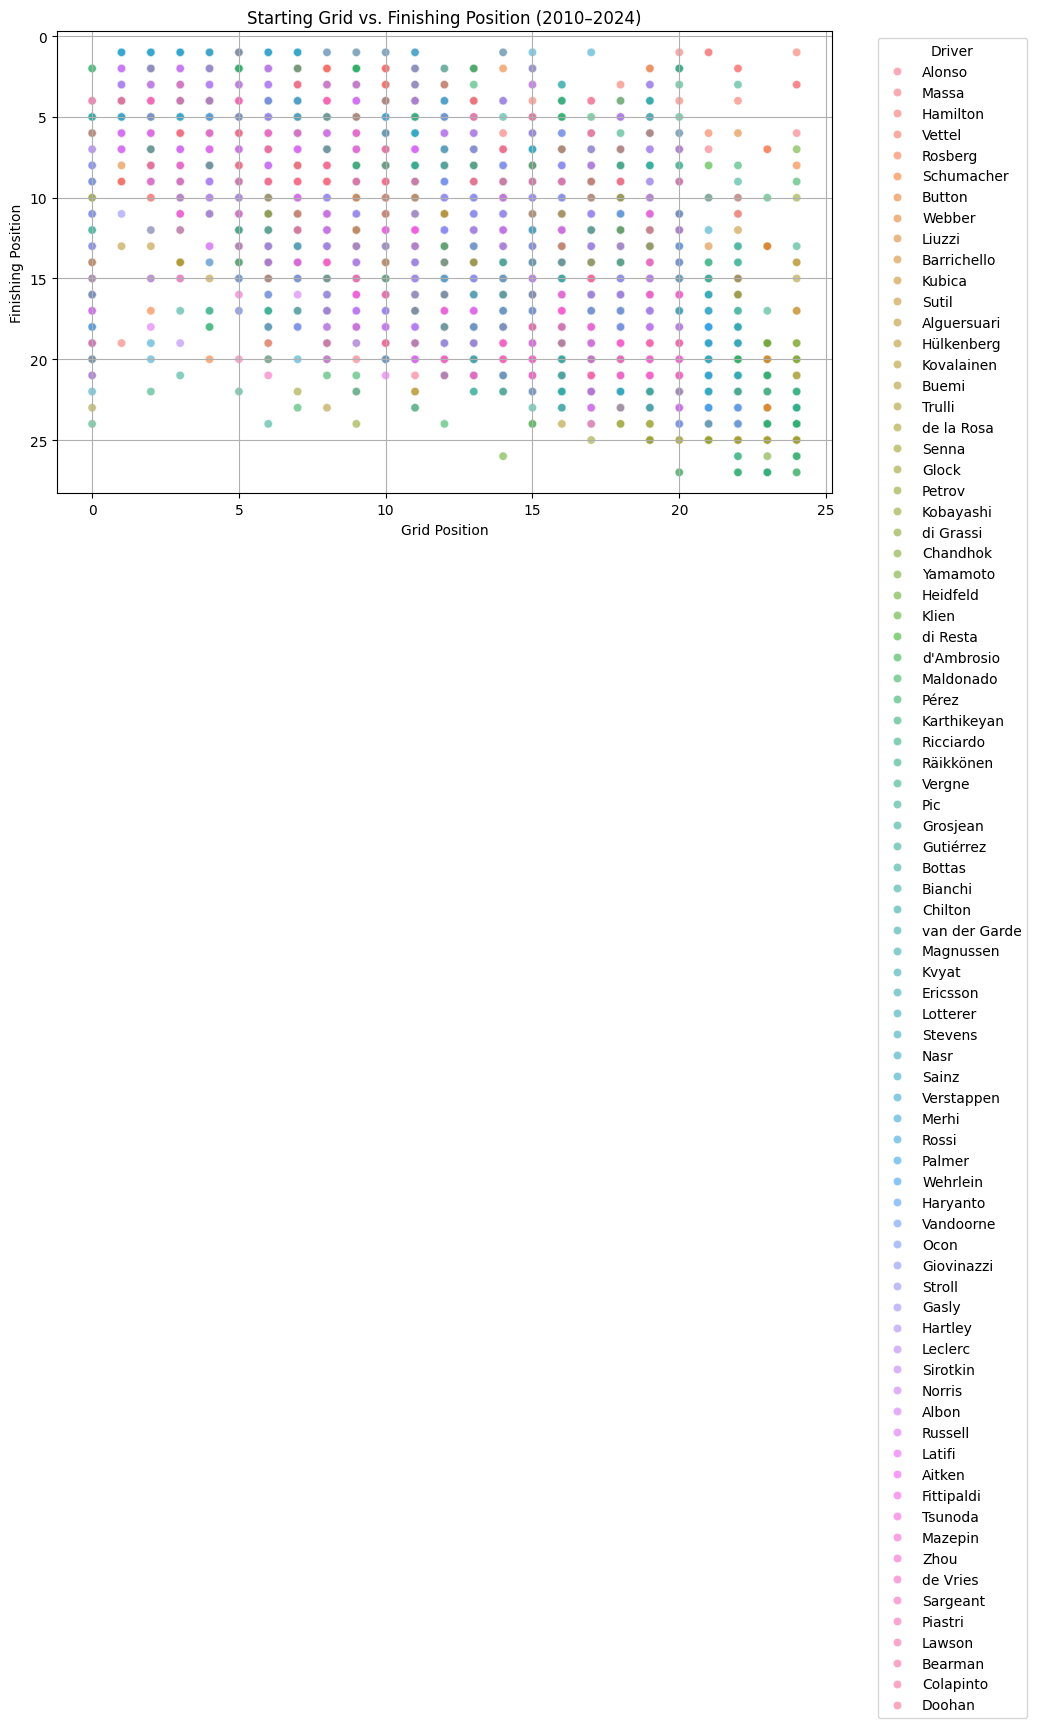

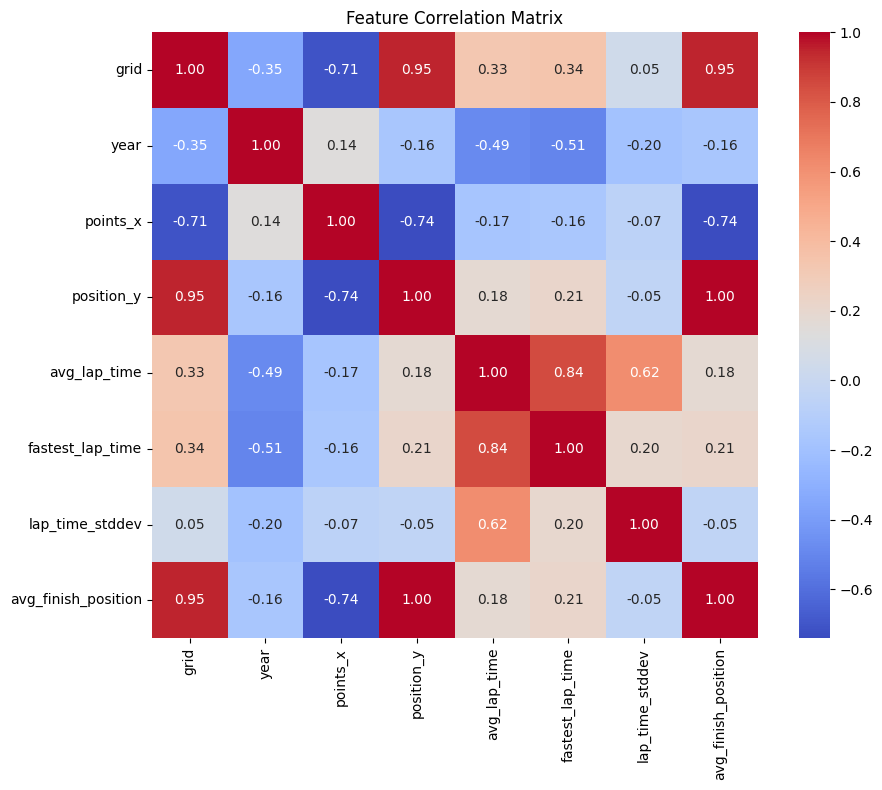

Random Forest MAE: 0.53
XGBoost MAE: 1.56
Using Random Forest model


In [53]:
# Load datasets

results = pd.read_csv(os.path.join(path, "results.csv"))
races = pd.read_csv(os.path.join(path, "races.csv"))
drivers = pd.read_csv(os.path.join(path, "drivers.csv"))
constructors = pd.read_csv(os.path.join(path, "constructors.csv"))
constructor_results = pd.read_csv(os.path.join(path, "constructor_results.csv"))
driver_standings = pd.read_csv(os.path.join(path, "driver_standings.csv"))
lap_times = pd.read_csv(os.path.join(path, "lap_times.csv"))


emilia_race_ids = races[races['name'].str.contains('Emilia', case=False)]['circuitId'].tolist()

print(emilia_race_ids)


lap_features = lap_times.groupby(['raceId', 'driverId'])['milliseconds'].agg([
    ('avg_lap_time', 'mean'),
    ('fastest_lap_time', 'min'),
    ('lap_time_stddev', 'std')
]).reset_index()


full_data = results.merge(races, on='raceId', how='left') \
    .merge(drivers, on='driverId', how='left') \
    .merge(constructors, on='constructorId', how='left') \
    .merge(constructor_results, on=['raceId', 'constructorId'], how='left') \
    .merge(driver_standings, on=['raceId', 'driverId'], how='left')\
    .merge(lap_features, on=['raceId', 'driverId'], how='left')


data = full_data[(full_data['year'] >= 2010) & (full_data['year'] <= 2024)]



data['grid'] = pd.to_numeric(data['grid'], errors='coerce').fillna(data['grid'].median())
data['points_x'] = pd.to_numeric(data['points_x'], errors='coerce').fillna(0)
data['position_y'] = pd.to_numeric(data['position_y'], errors='coerce').fillna(data['position_y'].median())
data['avg_lap_time'] = data['avg_lap_time'].fillna(data['avg_lap_time'].mean())
data['fastest_lap_time'] = data['fastest_lap_time'].fillna(data['fastest_lap_time'].mean())
data['lap_time_stddev'] = data['lap_time_stddev'].fillna(data['lap_time_stddev'].mean())
data['position'] = pd.to_numeric(data['positionOrder'], errors='coerce')

# Filter only Albon and Sainz
target_drivers = ['Albon', 'Sainz']
data_filtered = data[data['surname'].isin(target_drivers) & data['circuitId'].isin(emilia_race_ids)]
williams_id = constructors[constructors['name'].str.contains('Williams', case=False)]['constructorId'].values[0]


features = ['grid', 'year', 'points_x', 'position_y', 'avg_lap_time', 'fastest_lap_time', 'lap_time_stddev']


driver_stats = data_filtered.groupby('surname').agg(
    avg_finish_position=('position_y', 'mean'),
    podium_finishes=('position_y', lambda x: (x <= 3).sum()),
    total_points=('points', 'sum'),grid=('grid', 'mean'),
    year=('year', 'mean'),
    points_x=('points_x', 'sum'),
    position_y=('position_y', 'mean'),
    avg_lap_time=('avg_lap_time', 'mean'),
    fastest_lap_time=('fastest_lap_time', 'mean'),
    lap_time_stddev=('lap_time_stddev', 'mean')
).reset_index().set_index('surname')

print(driver_stats)

full_driver_stats = data.groupby('driverId').agg(
    avg_finish_position=('position_y', 'mean'),
    podium_finishes=('position_y', lambda x: (x <= 3).sum()),
    total_points=('points', 'sum'),
    grid=('grid', 'mean'),
    year=('year', 'mean'),
    points_x=('points_x', 'sum'),
    position_y=('position_y', 'mean'),
    avg_lap_time=('avg_lap_time', 'mean'),
    fastest_lap_time=('fastest_lap_time', 'mean'),
    lap_time_stddev=('lap_time_stddev', 'mean')
).reset_index()

full_driver_stats = full_driver_stats.merge(drivers[['driverId', 'surname']], on='driverId')
X = full_driver_stats[features]
y = full_driver_stats['avg_finish_position']


plt.figure(figsize=(12, 6))
for driver in target_drivers:
    subset = data_filtered[data_filtered['surname'] == driver]
    sns.kdeplot(subset['avg_lap_time'], label=driver)

plt.title('Average Lap Time Distribution - Emilia-Romagna (2010–2024)')
plt.xlabel('Average Lap Time (ms)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='grid', y='position_y', hue='surname', alpha=0.6)

plt.title('Starting Grid vs. Finishing Position (2010–2024)')
plt.xlabel('Grid Position')
plt.ylabel('Finishing Position')
plt.gca().invert_yaxis()
plt.legend(title='Driver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
corr_matrix = full_driver_stats[features + ['avg_finish_position']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [100,150, 200],
    'max_depth': [8, 10, 20],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_

rf_preds = best_rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_preds)
print(f"Random Forest MAE: {rf_mae:.2f}")


xgb_model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.01, max_depth=8, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

xgb_preds = xgb_model.predict(X_test_scaled)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
print(f"XGBoost MAE: {xgb_mae:.2f}")


if rf_mae < xgb_mae:
    print("Using Random Forest model")
    final_model = best_rf_model
else:
    print("Using XGBoost model")
    final_model = xgb_model



In [54]:
preds = final_model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, preds)
print(f"Mean Absolute Error: {mae:.2f}")


Mean Absolute Error: 0.53


In [55]:
upcoming_race_input = driver_stats[features]
upcoming_race_input = upcoming_race_input.loc[target_drivers]

predictions = final_model.predict(upcoming_race_input)


prediction_df = pd.DataFrame({
    'Driver': upcoming_race_input.index,
    'Predicted_Finish_Position': np.round(predictions).astype(int)
}).reset_index(drop=True)

print(prediction_df)

  Driver  Predicted_Finish_Position
0  Albon                         14
1  Sainz                          8


In [56]:
# F1 Points table
f1_points = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}


# Calculate Constructors' points for Williams
williams_points = 0
for position in np.round(predictions).astype(int):
  williams_points += f1_points.get(position, 0)

print(f"Predicted Constructors’ points for Williams in Emilia-Romagna: {williams_points}")


Predicted Constructors’ points for Williams in Emilia-Romagna: 4
